In [1]:
import sys
print(sys.executable)
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())


/usr/bin/python


In [2]:
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())
from loader.dataloader import VideoDataSet,VideoDataLoader
import torch


dataset ="50salads"
split_test = "test.split2.bundle"
split_train = "train.split2.bundle"

default_path="./data/data/"
knowns = ["cut_tomato",
          "place_tomato_into_bowl",
          "cut_cheese",
          "place_cheese_into_bowl",
          "cut_lettuce",
          "place_lettuce_into_bowl",
          "add_salt",
          "add_vinegar",
          "add_oil",
          "add_pepper",
          "mix_dressing",
          "peel_cucumber",
          "cut_cucumber",
          "place_cucumber_into_bowl",
          "add_dressing",
          "mix_ingredients",
          "serve_salad_onto_plate",
          "action_start",
          "action_end",
          ]
unknowns = []
video_dataset_test = VideoDataSet(dataset=dataset,
                               split=split_test,
                               default_path=default_path,
                               knowns=knowns,
                               unknowns=unknowns,
)
data_loader_test = VideoDataLoader(video_dataset_test, batch_size=1, shuffle=False)

video_dataset_train = VideoDataSet(dataset=dataset,
                               split=split_train,
                               default_path=default_path,
                               knowns=knowns,
                               unknowns=unknowns,
)
data_loader_train = VideoDataLoader(video_dataset_train, batch_size=1, shuffle=False)

In [22]:
from model.bert import ActionBERT, ActionBERTConfig
import torch.nn.functional as F

knowns = ["cut_tomato",
          "place_tomato_into_bowl",
          "cut_cheese",
          "place_cheese_into_bowl",
          "cut_lettuce",
          "place_lettuce_into_bowl",
          "add_salt",
          "add_vinegar",
          "add_oil",
          "add_pepper",
          "mix_dressing",
          "peel_cucumber",
          "cut_cucumber",
          "place_cucumber_into_bowl",
          "add_dressing",
          "mix_ingredients",
          "serve_salad_onto_plate",
          "action_start",
          "action_end",
          ]
unknowns = []
train_for_knowns = True

bert_conf = ActionBERTConfig(
    known_classes=knowns,
    input_dim=2048,
    d_model=256,
    num_heads=8,
    num_layers=3,
    local_window_size=128,
    window_dilation=32,
    dropout=0)
model = ActionBERT(config=bert_conf, train_for_knowns=train_for_knowns)

path = "./output/actionbert_full_known_split2.pth"

state_dict = torch.load(path, map_location=torch.device('cuda'))
model.load_state_dict(state_dict, strict=False)
model = model.to('cuda')
model.eval()
print("Modell erfolgreich geladen.")

def get_model_pred(features,padding_mask):
    unknown_mask = torch.zeros_like(padding_mask).bool()
    res  = model(features,padding_mask)
    
    
    """pred_dist_start = torch.exp(boundaries[:, :, 0]) - 1
    pred_dist_end   = torch.exp(boundaries[:, :, 1]) - 1
   # pred_dist_start = torch.clamp(pred_dist_start, min=0)
    #pred_dist_end   = torch.clamp(pred_dist_end, min=0)
    
    B, T = pred_dist_start.shape
    device = pred_dist_start.device
    
   
    t_indices = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
    vote_start = torch.round(t_indices - pred_dist_start).long()
    vote_end   = torch.round(t_indices + pred_dist_end ).long()
    """
    softmax_logits = F.softmax(res["refine_logits"], dim=-1)  
    class_labels = torch.argmax(softmax_logits,dim=-1)
   
    return class_labels
    
def _generate_structured_mask( features, mask_ratio=0.75, block_size=64):
        """
        Structured Masking: Unterteilt das Video in Blöcke der Größe 'block_size'.
        In JEDEM Block werden 'mask_ratio' Prozent maskiert.
        Das verhindert riesige Lücken und garantiert eine gleichmäßige Schwierigkeit.
        """
        B, S, D = features.size()
        mask = torch.zeros((B, S), dtype=torch.bool)

        mask_len_per_block = int(block_size * mask_ratio)

        for t in range(0, S, block_size):
            end_t = min(t + block_size, S)
            actual_block_len = end_t - t

            curr_mask_len = int(actual_block_len * mask_ratio)

            if curr_mask_len == 0:
                continue

            max_start = actual_block_len - curr_mask_len

            if max_start > 0:

                rel_starts = torch.randint(0, max_start, (B,))

                for b in range(B):
                    abs_start = t + rel_starts[b].item()
                    mask[b, abs_start: abs_start + curr_mask_len] = True
            else:
                mask[:, t:end_t] = True

        return mask.to('cuda')


Modell erfolgreich geladen.


/tmp/ipykernel_27281/2061919811.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device('cuda'))


In [60]:
i = 0
for batch_test in data_loader_test:
    features = batch_test["features"]
    unknown_mask = batch_test["unknown_mask"]
    target_truth = batch_test["target_truth"]
    padding_mask = batch_test["padding_mask"]
    labels_dict = batch_test["labels_dict"]
    remap_dict = batch_test["remap_dict"]
    target_start = batch_test['target_start']
    target_end = batch_test['target_end']
   
    if i == 8:
        break
    i +=1
   
    
    
for batch_train in data_loader_train:

   
   
   
   
    
    break

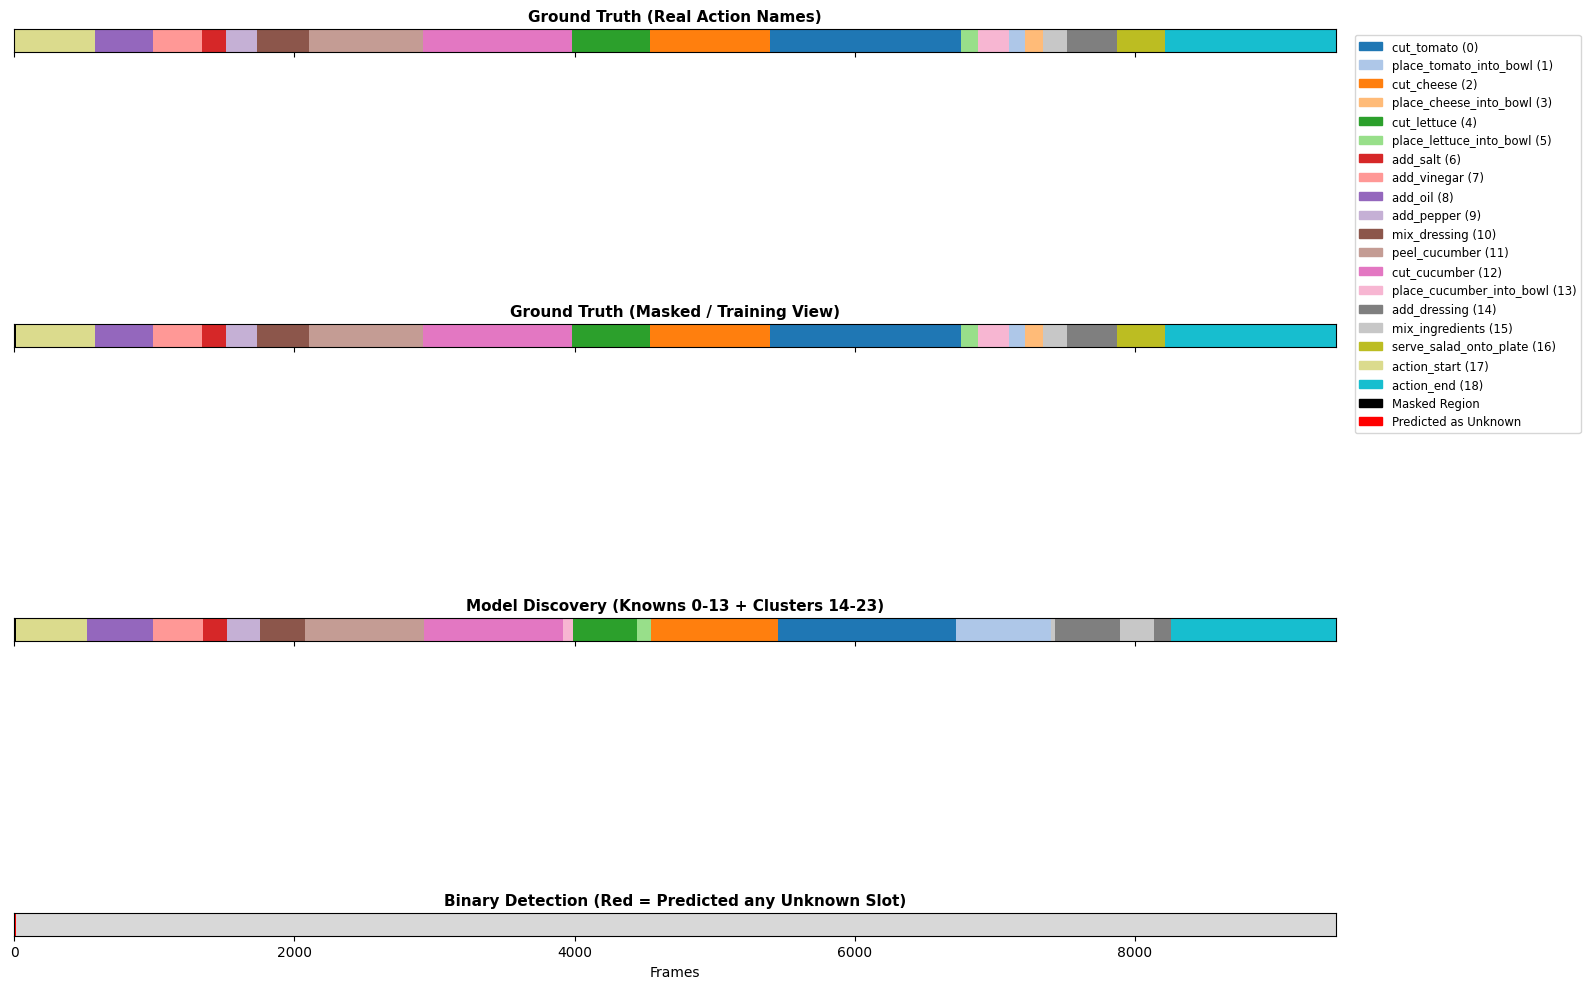

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

# --- KONFIGURATION ---
NUM_KNOWNS = 19        # Bekannte Klassen (0-13)
NUM_PSEUDO_UNKNOWNS = 0 # Deine 10 Pseudo-Slots (14-23)
FIRST_UNK_ID = NUM_KNOWNS
LAST_UNK_ID = NUM_KNOWNS + NUM_PSEUDO_UNKNOWNS - 1


unk = ["add_oil",
               "add_vinegar",
               "cut_cheese",
               "mix_dressing",
               "mix_ingredients",
               "place_lettuce_into_bowl"]




# 1. Model Prediction (jetzt 0 bis 23)
# Wir gehen davon aus, dass get_model_pred den argmax über alle 24 Klassen liefert
res = get_model_pred(features.to('cuda'), padding_mask.to('cuda'))
if isinstance(res, tuple): res = res[0] # Falls (res, unk) zurückkommt, nimm res
res = res.squeeze(0).cpu().numpy()

pad_mask_np = padding_mask.squeeze(0).cpu().numpy().astype(bool)
unknown_mask_np = unknown_mask.squeeze(0).cpu().numpy().astype(bool)
target_truth_np = target_truth.squeeze(0).cpu().numpy()

# Filtern (Padding weg)
target_truth_valid = target_truth_np[pad_mask_np]
unknown_mask_valid  = torch.tensor(
            [labels_dict[name] for name in unk],
            device=target_truth.device
        )

res_valid = res[pad_mask_np]

print()
# --- 2. ID-Mapping ---
raw_dict = labels_dict
if isinstance(raw_dict, list): raw_dict = raw_dict[0]
id_to_name = {v: k for k, v in raw_dict.items()}

# --- 3. Farb-Palette (Erweitert für viele Cluster) ---
# Wir kombinieren mehrere Maps, damit die 10 Cluster unterschiedliche Farben haben
colors_main = plt.get_cmap('tab20').colors
colors_extra = plt.get_cmap('Set3').colors # Hellere Töne für Cluster
base_colors = np.vstack((colors_main, colors_extra))

max_id_present = max(target_truth_valid.max(), res_valid.max(), LAST_UNK_ID)
while len(base_colors) <= max_id_present + 5:
    base_colors = np.vstack((base_colors, base_colors))

color_lut = base_colors.copy()
BLACK_ID = len(color_lut) - 1
color_lut[BLACK_ID] = [0.0, 0.0, 0.0] 

# --- 4. Plot-Daten vorbereiten ---

# GT Real: Zeigt die echten Namen aus dem Dataset (z.B. 15, 16, 17...)
gt_full = target_truth_valid

# GT Masked: Alles Unknown wird schwarz (Trainings-Sicht)
gt_masked = target_truth_valid.copy()
gt_masked[unknown_mask_valid] = BLACK_ID 

# Prediction: Die 14 Knowns + die 10 Pseudo-Cluster (Discovery)
pred_discovery = res_valid 
pred_discovery[unknown_mask_valid] = BLACK_ID
# Binary Detection: Hat das Modell IRGENDEINEN Slot >= 14 gewählt?
# Wir nutzen Rot für "Modell sagt Unknown" und Hellgrau für "Modell sagt Known"
DETECTION_UNK_COLOR = [1.0, 0.0, 0.0]
DETECTION_KNOWN_COLOR = [0.85, 0.85, 0.85]
color_lut = np.vstack((color_lut, DETECTION_UNK_COLOR, DETECTION_KNOWN_COLOR))
IDX_RED = len(color_lut) - 2
IDX_GRAY = len(color_lut) - 1

detection_binary = np.where(res_valid >= FIRST_UNK_ID, IDX_RED, IDX_GRAY)

plots_data = [
    ("Ground Truth (Real Action Names)", gt_full),      
    ("Ground Truth (Masked / Training View)", gt_masked),
    ("Model Discovery (Knowns 0-13 + Clusters 14-23)", pred_discovery),
    ("Binary Detection (Red = Predicted any Unknown Slot)", detection_binary)
]

# --- 5. Plotten ---
fig, axs = plt.subplots(nrows=len(plots_data), ncols=1, figsize=(16, 10), sharex=True)

for i, (title, data_indices) in enumerate(plots_data):
    rgb_image = color_lut[data_indices]
    rgb_image = rgb_image[np.newaxis, :, :] 
    axs[i].imshow(rgb_image, aspect='auto', interpolation='nearest')
    axs[i].set_title(title, fontsize=11, fontweight='bold')
    axs[i].set_yticks([]) 
    if i == len(plots_data) - 1: axs[i].set_xlabel("Frames")

# --- 6. Legende ---
patches = []

# A. Known Actions
for i in range(NUM_KNOWNS):
    if i in id_to_name:
        patches.append(mpatches.Patch(color=color_lut[i], label=f"{id_to_name[i]} ({i})"))

# B. Pseudo-Unknown Clusters (14-23)
for i in range(FIRST_UNK_ID, LAST_UNK_ID + 1):
    patches.append(mpatches.Patch(color=color_lut[i], label=f"Discovery Cluster {i}"))

# C. GT Unknowns (falls IDs im Datensatz höher sind, z.B. 50Salads hat IDs bis 48)
unique_gt = np.unique(gt_full)
for uid in unique_gt:
    if uid >= FIRST_UNK_ID and uid not in range(FIRST_UNK_ID, LAST_UNK_ID + 1) and uid != BLACK_ID:
        name = id_to_name.get(uid, f"GT Class {uid}")
        patches.append(mpatches.Patch(color=color_lut[uid], label=f"{name} (GT only)"))

# D. Zusatz-Infos
patches.append(mpatches.Patch(color=[0,0,0], label="Masked Region"))
patches.append(mpatches.Patch(color=[1,0,0], label="Predicted as Unknown"))

axs[0].legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize='small')

plt.tight_layout()
plt.show()

Unknown Detection -> F1@50: 0.00 (Prec: 0.00, Rec: 0.00)


/tmp/ipykernel_27281/3219229954.py:234: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


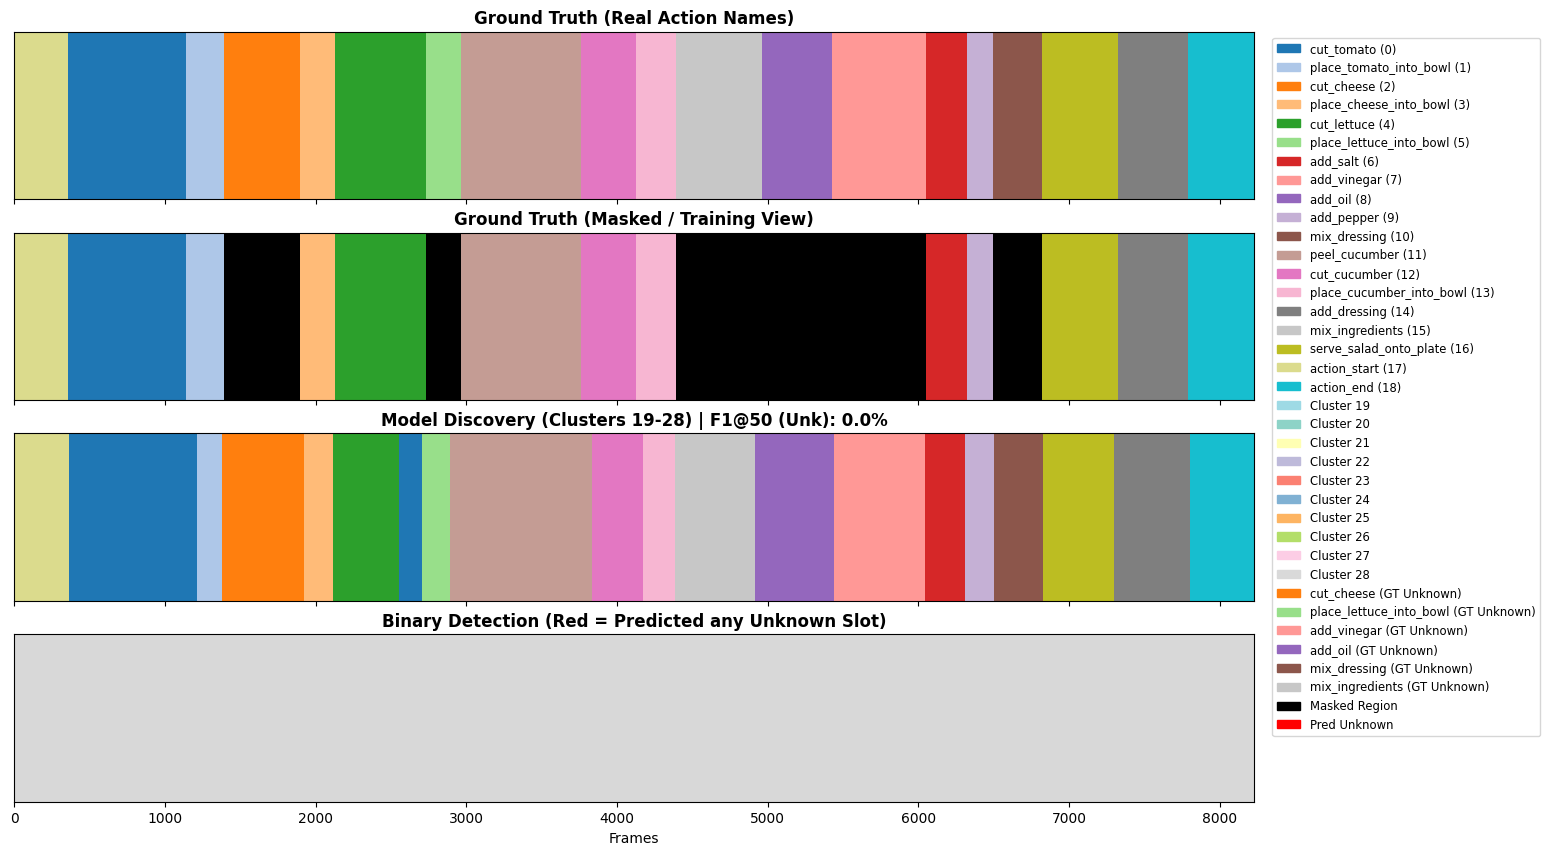

In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

# --- HILFSFUNKTIONEN FÜR F1 SCORE ---

def get_segments(sequence, target_class=1):
    """
    Wandelt eine binäre Sequenz (Numpy Array) in eine Liste von Segmenten um.
    Rückgabe: Liste von Tupeln (start, end) für die gesuchte Klasse.
    """
    segments = []
    if len(sequence) == 0:
        return segments
    
    # Änderungen finden
    # Wir fügen False am Anfang und Ende hinzu, um Flanken zu erkennen
    extended = np.concatenate(([False], sequence == target_class, [False]))
    diff = np.diff(extended.astype(int))
    
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0] - 1
    
    for s, e in zip(starts, ends):
        segments.append((s, e))
        
    return segments

def calculate_iou(seg1, seg2):
    """Berechnet Intersection over Union zwischen zwei Segmenten (start, end)."""
    s1, e1 = seg1
    s2, e2 = seg2
    
    # Intersection
    inter_s = max(s1, s2)
    inter_e = min(e1, e2)
    
    if inter_e < inter_s:
        return 0.0
        
    intersection = inter_e - inter_s + 1
    
    # Union
    len1 = e1 - s1 + 1
    len2 = e2 - s2 + 1
    union = len1 + len2 - intersection
    
    return intersection / union

def calculate_f1_at_k(pred_seq, gt_seq, k=0.5):
    """
    Berechnet den F1 Score bei Overlap k.
    Hier binär: Wir betrachten nur "Unknown" (1) vs "Known" (0).
    """
    pred_segs = get_segments(pred_seq, target_class=1)
    gt_segs = get_segments(gt_seq, target_class=1)
    
    tp = 0
    fp = 0
    fn = 0
    
    # Prüfe True Positives und False Negatives (aus Sicht der GT Segmente)
    # Ein GT Segment ist TP, wenn es ein passendes Pred Segment gibt
    matched_pred_indices = set()
    
    for gt_seg in gt_segs:
        is_detected = False
        for i, pred_seg in enumerate(pred_segs):
            iou = calculate_iou(gt_seg, pred_seg)
            if iou >= k:
                is_detected = True
                matched_pred_indices.add(i)
                # Wir brechen hier ab: Ein GT Segment zählt nur einmal als gefunden
                # (abhängig von Metrik-Definition, meistens reicht 1 Match)
                break 
        
        if is_detected:
            tp += 1
        else:
            fn += 1
            
    # False Positives: Pred Segmente, die kein GT Segment getroffen haben
    # (Dies ist eine strikte Auslegung. In manchen Papers ist FP einfach len(pred) - TP)
    fp = len(pred_segs) - tp 

    if tp == 0:
        return 0.0, 0.0, 0.0 # Precision, Recall, F1
        
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
        
    return f1, precision, recall


# --- HAUPT LOGIK ---

# 0. Setup & Konfiguration
NUM_KNOWNS = 19
NUM_PSEUDO_UNKNOWNS = 10 
FIRST_UNK_ID = NUM_KNOWNS
LAST_UNK_ID = NUM_KNOWNS + NUM_PSEUDO_UNKNOWNS - 1

unk_names = [
    "add_oil", "add_vinegar", "cut_cheese", "mix_dressing", 
    "mix_ingredients", "place_lettuce_into_bowl"
]

# 1. Prediction holen
res = get_model_pred(features.to('cuda'), padding_mask.to('cuda'))
if isinstance(res, tuple): res = res[0]
res = res.squeeze(0).cpu().numpy()

# 2. Masken & Daten vorbereiten
pad_mask_np = padding_mask.squeeze(0).cpu().numpy().astype(bool)
target_truth_np = target_truth.squeeze(0).cpu().numpy()

# Nur valide (non-padding) Bereiche
target_truth_valid = target_truth_np[pad_mask_np]
res_valid = res[pad_mask_np]

# IDs der Unknown Klassen bestimmen
unk_ids = [labels_dict[name] for name in unk_names]

# Logik Masken: 
# is_gt_unknown: True wo Ground Truth eine Unknown Klasse ist
is_gt_unknown = np.isin(target_truth_valid, unk_ids)

# is_pred_unknown: True wo Model einen Cluster (>= 19) vorhergesagt hat
is_pred_unknown = (res_valid >= FIRST_UNK_ID)

# 3. F1 SCORE BERECHNEN (Hier passiert die Magie)
# Wir übergeben binäre Arrays (1 für Unknown, 0 für Known)
f1_score, prec, rec = calculate_f1_at_k(
    pred_seq=is_pred_unknown.astype(int), 
    gt_seq=is_gt_unknown.astype(int), 
    k=0.50
)

print(f"Unknown Detection -> F1@50: {f1_score:.2f} (Prec: {prec:.2f}, Rec: {rec:.2f})")


# 4. Plot Vorbereitung
raw_dict = labels_dict
if isinstance(raw_dict, list): raw_dict = raw_dict[0]
id_to_name = {v: k for k, v in raw_dict.items()}

# Farben
colors_main = plt.get_cmap('tab20').colors
colors_extra = plt.get_cmap('Set3').colors 
base_colors = np.vstack((colors_main, colors_extra))

max_id_present = max(target_truth_valid.max(), res_valid.max(), LAST_UNK_ID)
while len(base_colors) <= max_id_present + 5:
    base_colors = np.vstack((base_colors, base_colors))

color_lut = base_colors.copy()
BLACK_ID = len(color_lut) - 1
color_lut[BLACK_ID] = [0.0, 0.0, 0.0] 

# Daten für Visualisierung
# GT Full: Alles wie es ist
gt_full = target_truth_valid.copy()

# GT Masked: Unknowns schwarz färben (Simuliert Training View)
gt_masked = target_truth_valid.copy()
gt_masked[is_gt_unknown] = BLACK_ID 

# Prediction:
pred_discovery = res_valid.copy()
# Wenn du die GT Unknowns in der Pred auch schwarz maskieren willst (Optional):
# pred_discovery[is_gt_unknown] = BLACK_ID 
# Normalerweise will man aber sehen, was das Modell dort vorhersagt.

# Binary Detection
DETECTION_UNK_COLOR = [1.0, 0.0, 0.0]    # Rot
DETECTION_KNOWN_COLOR = [0.85, 0.85, 0.85] # Grau
color_lut = np.vstack((color_lut, DETECTION_UNK_COLOR, DETECTION_KNOWN_COLOR))
IDX_RED = len(color_lut) - 2
IDX_GRAY = len(color_lut) - 1

detection_binary = np.where(res_valid >= FIRST_UNK_ID, IDX_RED, IDX_GRAY)

plots_data = [
    ("Ground Truth (Real Action Names)", gt_full),      
    ("Ground Truth (Masked / Training View)", gt_masked),
    # F1 Score in den Titel einfügen
    (f"Model Discovery (Clusters {FIRST_UNK_ID}-{LAST_UNK_ID}) | F1@50 (Unk): {f1_score*100:.1f}%", pred_discovery),
    ("Binary Detection (Red = Predicted any Unknown Slot)", detection_binary)
]

# 5. Plotten
fig, axs = plt.subplots(nrows=len(plots_data), ncols=1, figsize=(16, 10), sharex=True)

for i, (title, data_indices) in enumerate(plots_data):
    # Sicherstellen, dass Indizes im Bereich der Colormap sind
    data_indices = np.clip(data_indices, 0, len(color_lut)-1)
    
    rgb_image = color_lut[data_indices]
    rgb_image = rgb_image[np.newaxis, :, :] 
    axs[i].imshow(rgb_image, aspect='auto', interpolation='nearest')
    axs[i].set_title(title, fontsize=12, fontweight='bold')
    axs[i].set_yticks([]) 
    if i == len(plots_data) - 1: axs[i].set_xlabel("Frames")

# 6. Legende
patches = []
# Known Actions
for i in range(NUM_KNOWNS):
    if i in id_to_name:
        patches.append(mpatches.Patch(color=color_lut[i], label=f"{id_to_name[i]} ({i})"))

# Pseudo-Unknown Clusters
for i in range(FIRST_UNK_ID, LAST_UNK_ID + 1):
    patches.append(mpatches.Patch(color=color_lut[i], label=f"Cluster {i}"))

# GT Unknowns
unique_gt = np.unique(gt_full)
for uid in unique_gt:
    if uid in unk_ids:
        name = id_to_name.get(uid, f"GT Class {uid}")
        patches.append(mpatches.Patch(color=color_lut[uid], label=f"{name} (GT Unknown)"))

patches.append(mpatches.Patch(color=[0,0,0], label="Masked Region"))
patches.append(mpatches.Patch(color=[1,0,0], label="Pred Unknown"))

axs[0].legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, fontsize='small')

plt.tight_layout()
plt.show()

Vorhandene Klassen in Train-Fenster: tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 12, 14, 16])
Vorhandene Klassen in Test-Fenster: tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 12, 14, 16])


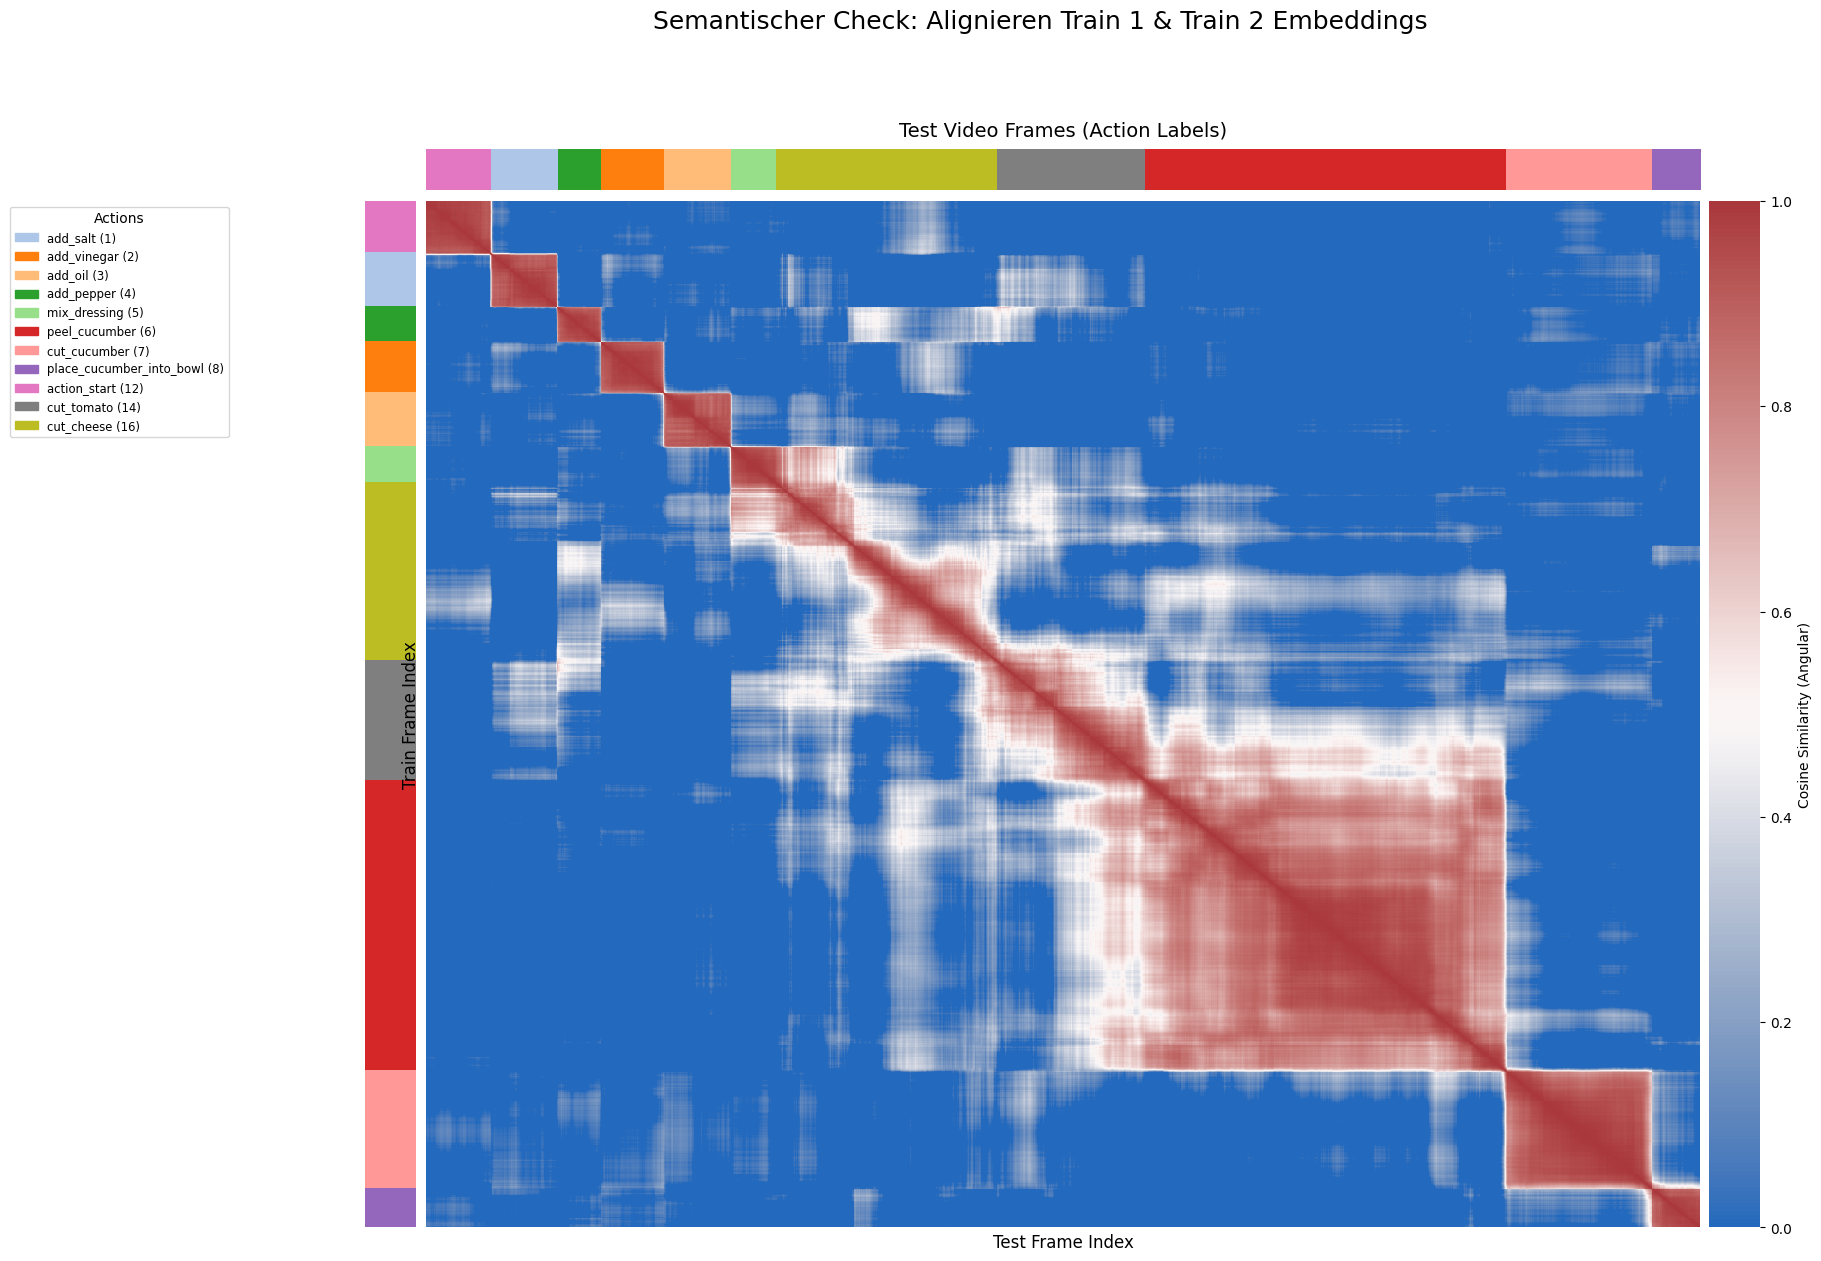

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap

def get_alignment_data(model, train_batch, test_batch, device, num_frames=2000):
    """
    Inferiert Embeddings für ein Train- und ein Test-Video und berechnet die Ähnlichkeit.
    """
    model.eval()
    model.to(device)
    
 
    
    with torch.no_grad():
        # Inferenz
        start_one = 300
        start_two =300
        out_train = model(train_batch["features"].to(device), None, train_batch["padding_mask"].to(device))
        out_test = model(test_batch["features"].to(device), None, test_batch["padding_mask"].to(device))
        
        # Embeddings extrahieren & normalisieren (Angular Space)
        # Shape: [num_frames, d_model]
        # 1. Rohe Embeddings extrahieren (noch nicht normalisiert!)
        raw_train = out_train["embeddings"][0] # [T, 256]
        raw_test = out_test["embeddings"][0]   # [T, 256]

        #raw_train = train_batch["features"].to(device)[0]
        #raw_test = train_batch["features"].to(device)[0]

        # --- DER CENTERING FIX ---
        # Wir berechnen den Mittelwert über das GESAMTE Video (oder den Batch)
        # Das verschiebt den Schwerpunkt der Wolke auf den Nullpunkt.
        mean_train = raw_train.mean(dim=0, keepdim=True)
        mean_test = raw_test.mean(dim=0, keepdim=True)

        centered_train = raw_train #- mean_train
        centered_test = raw_test #- mean_test
        # --------------------------

        # 2. Slicing der gewünschten Fenster aus den zentrierten Daten
        # Danach L2-Normalisierung für den Angular Space
        emb_train = F.normalize(centered_train[start_one:start_one+num_frames, :], p=2, dim=-1)
        emb_test = F.normalize(centered_test[start_two:start_two+num_frames, :], p=2, dim=-1)
        
        # 3. Ground Truth Labels extrahieren (bleibt gleich)
        gt_train = train_batch["target_truth"][0, start_one:start_one+num_frames].cpu().numpy()
        gt_test = test_batch["target_truth"][0, start_two:start_two+num_frames].cpu().numpy()
        
        print("Vorhandene Klassen in Train-Fenster:", torch.unique(torch.tensor(gt_train)))
        print("Vorhandene Klassen in Test-Fenster:", torch.unique(torch.tensor(gt_test)))

    # 4. Ähnlichkeitsmatrix berechnen (Cosine Similarity via MatMul)
    # Da wir zentriert und normalisiert haben, ist das Ergebnis jetzt 
    # über die gesamte Kugel verteilt (-1.0 bis 1.0)
    similarity_matrix = torch.matmul(emb_train, emb_test.t()).cpu().numpy()

    return similarity_matrix, gt_train, gt_test

def plot_alignment_matrix(similarity_matrix, gt_train, gt_test, color_lut, id_to_name, title="Cross-Domain Affinity"):
    """
    Erstellt eine Heatmap mit den EXAKT gleichen Farben wie im Bar-Plot.
    """
    fig = plt.figure(figsize=(18, 14))
    
    # Grid-Layout: [Links-Labels, Haupt-Heatmap, Colorbar-Platz]
    gs = plt.GridSpec(2, 3, 
                      width_ratios=[1, 25, 1], 
                      height_ratios=[1, 25], 
                      hspace=0.02, wspace=0.02)

    ax_top = fig.add_subplot(gs[0, 1])
    ax_left = fig.add_subplot(gs[1, 0])
    ax_main = fig.add_subplot(gs[1, 1], sharex=ax_top, sharey=ax_left)
    ax_cbar = fig.add_subplot(gs[1, 2])

    # --- DIE FARB-LOGIK ---
    # Wir erstellen eine Matplotlib-Colormap aus deiner color_lut
    custom_cmap = ListedColormap(color_lut)
    # vmin und vmax müssen den Index-Bereich deiner color_lut abdecken
    v_min = 0
    v_max = len(color_lut) - 1

    # 1. Test-Labels (Oben)
    ax_top.imshow(gt_test[None, :], aspect='auto', cmap=custom_cmap, 
                  interpolation='nearest', vmin=v_min, vmax=v_max)
    ax_top.set_axis_off()
    ax_top.set_title("Test Video Frames (Action Labels)", fontsize=14, pad=10)

    # 2. Train-Labels (Links)
    ax_left.imshow(gt_train[:, None], aspect='auto', cmap=custom_cmap, 
                   interpolation='nearest', vmin=v_min, vmax=v_max)
    ax_left.set_axis_off()

    # 3. Haupt-Heatmap (Ähnlichkeit)
    sns.heatmap(similarity_matrix, ax=ax_main, cmap='vlag', center=0.5, 
                vmin=0, vmax=1, cbar_ax=ax_cbar, 
                cbar_kws={'label': 'Cosine Similarity (Angular)'})
    
    ax_main.set_xlabel("Test Frame Index", fontsize=12)
    ax_main.set_ylabel("Train Frame Index", fontsize=12)
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    # --- LEGENDE HINZUFÜGEN (analog zum anderen Plot) ---
    patches = []
    # Alle IDs finden, die in diesen Ausschnitten vorkommen
    unique_ids = np.unique(np.concatenate([gt_train, gt_test]))
    for uid in sorted(unique_ids):
        if uid == len(color_lut) - 1: # Black / Masked
            patches.append(mpatches.Patch(color=[0,0,0], label="Masked"))
        elif uid in id_to_name:
            patches.append(mpatches.Patch(color=color_lut[int(uid)], label=f"{id_to_name[uid]} ({int(uid)})"))
        else:
            patches.append(mpatches.Patch(color=color_lut[int(uid)], label=f"Cluster {int(uid)}"))

    # Legende ganz links außen oder rechts platzieren
    ax_main.legend(handles=patches, bbox_to_anchor=(-0.15, 1.0), loc='upper right', 
                   fontsize='small', title="Actions")

    plt.suptitle(title, fontsize=18, y=0.98)
    plt.show()

# --- Ausführung ---
# Wir nutzen die Variablen (color_lut, id_to_name), die du im vorherigen Block definiert hast

# --- Ausführung ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
iterator = iter(data_loader_train)
b_train1 = next(iterator)
b_train2 = next(iterator)
# 1. Daten berechnen
sim_mat, gt_tr, gt_te = get_alignment_data(
    model, 
    b_train2, 
    b_train2, 
    DEVICE, 
    num_frames=9000
)

# 2. Visualisieren
plot_alignment_matrix(
    sim_mat, 
    gt_tr, 
    gt_te, 
    color_lut,   # <--- Hier übergeben
    id_to_name,  # <--- Hier übergeben
    title="Semantischer Check: Alignieren Train 1 & Train 2 Embeddings"
)

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import torch
import torch.nn.functional as F
start_one = 3900
start_two =3900

def analyze_centered_raw_features(model,train_batch, device, eps=0.5, min_samples=30):
    # 1. Rohe Features holen [T, 2048]
    out_train = model(train_batch["features"].to(device), None, train_batch["padding_mask"].to(device))["embeddings"]
    out_test = model(train_batch["features"].to(device), None, train_batch["padding_mask"].to(device))
    
    print(out_train.shape)
    raw_feats = out_train[0][start_one:start_one+600]
    gt = train_batch["target_truth"][0,start_one:start_one+600].cpu().numpy()
    
    # 2. Centering Fix (Den I3D-Klumpen auf den Nullpunkt schieben)
    video_mean = raw_feats.mean(dim=0, keepdim=True)
    centered_feats = raw_feats - video_mean
    
    # 3. Normalisierung (Angular Space ist Pflicht nach dem Centering)
    normed_feats = F.normalize(centered_feats, p=2, dim=-1).cpu().numpy()
    
    # 4. DBSCAN auf den zentrierten Roh-Features
    print(f"Starte DBSCAN auf zentrierten I3D-Features (eps={eps})...")
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(normed_feats)
    cluster_labels = db.labels_
    
    # 5. Visualisierung
    T = len(gt)
    fig, ax = plt.subplots(2, 1, figsize=(18, 5), sharex=True)
    
    # Plot 1: Ground Truth
    ax[0].imshow(gt[None, :], aspect='auto', interpolation='nearest', cmap='tab20')
    ax[0].set_yticks([])
    ax[0].set_ylabel("Ground\nTruth", rotation=0, labelpad=40, va='center', fontweight='bold')
    
    # Plot 2: DBSCAN Cluster
    # -1 (Noise) wird schwarz dargestellt
    ax[1].imshow(cluster_labels[None, :], aspect='auto', interpolation='nearest', cmap='Set1')
    ax[1].set_yticks([])
    ax[1].set_ylabel("DBSCAN\nCentered Raw", rotation=0, labelpad=40, va='center', fontweight='bold')
    
    plt.xlabel("Frames")
    plt.suptitle("Diagnose: Hilft Centering den rohen I3D Features?", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 6. Purity Analyse
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print(f"Gefundene Cluster: {n_clusters}")
    if n_clusters > 0:
        for c in range(min(n_clusters, 10)):
            mask = (cluster_labels == c)
            unique, counts = np.unique(gt[mask], return_counts=True)
            purity = 100 * np.max(counts) / np.sum(mask)
            print(f"Cluster {c}: Größe {np.sum(mask)} | Dominante Action: {unique[np.argmax(counts)]} | Reinheit: {purity:.1f}%")

# Aufruf
analyze_centered_raw_features(model,b_train1, "cpu", eps=0.5)

NameError: name 'b_train1' is not defined